In [86]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [52]:
data = pd.read_csv('data.txt')

In [53]:
data.head()

,1
0,ای رستخیز ناگهان، وی رحمت بی منتها\tای آتشی اف...
1,امروز خندان آمدی، مفتاح زندان آمدی\tبر مستمندا...
2,خورشید را حاجب تویی، امید را واجب تویی\tمطلب ت...
3,در سینه ها برخاسته، اندیشه را آراسته\tهم خویش ...
4,ای روح بخش بی بَدَل، وی لذتِ علم و عمل\tباقی ب...


In [54]:
with open('stopwords.txt') as stopwords_file:
  stopwords = stopwords_file.readlines()
stopwords = [line.replace('\n', '') for line in stopwords] 

In [55]:
stopwords[0:10]

['!', '"', '#', '(', ')', '*', ',', '-', '.', '/']

In [56]:
len(stopwords)

1316

In [57]:
text = [line.replace('\t', ' ') for line in data.values.flatten()]
text = [line.replace('-', ' ') for line in text]
text = [re.sub("\d+", "", t) for t in text]

In [58]:
text[0:15]

['ای رستخیز ناگهان، وی رحمت بی منتها ای آتشی افروخته، در بیشه ی اندیشه ها',
 'امروز خندان آمدی، مفتاح زندان آمدی بر مستمندان آمدی، چون بخشش و فضل خدا',
 'خورشید را حاجب تویی، امید را واجب تویی مطلب تویی طالب تویی، هم منتها، هم مبتدا',
 'در سینه ها برخاسته، اندیشه را آراسته هم خویش حاجت خواسته، هم خویشتن کرده روا',
 'ای روح بخش بی بَدَل، وی لذتِ علم و عمل باقی بهانه ست و دغل، کاین علت آمد، وآن دوا',
 'ما زان دغل کژ بین شده، با بی گنه در کین شده گه مست حورالعین شده، گه مست نان و شوربا',
 'این سُکر بین، هل عقل را، وین ُنقل بین، هل َنقل را کز بهر نان و بقل را، چندین نشاید ماجرا',
 'تدبیر صد رنگ افکنی، بر روم و بر زنگ افکنی واندر میان جنگ افکنی، فی اصطناع لا یری',
 'میمال پنهان گوش جان، مینه بهانه بر کسان جان رب خلصنی زنان، والله که لاغست ای کیا',
 'خامش که بس مستعجلم، رفتم سوی پای علم کاغذ بنه بشکن قلم، ساقی درآمد، الصلا',
 '',
 'ای طایران قدس را عشقت فزوده بال ها در حلقه ی سودای تو، روحانیان را حال ها',
 'در "لا احب الافلین"، پاکی ز صورت ها یقین در دیده های غیب بین، هر دم ز تو تمثال ها',


In [59]:
!pip install hazm
from hazm import word_tokenize

In [60]:
word_tokenized = [word_tokenize(t) for t in text]
word_tokenized_filtered = [[w for w in sentence if w not in stopwords] for sentence in word_tokenized]

In [61]:
#example
word_tokenized_filtered[14]

['کوه',
 'غمت',
 'بشکافته',
 'وآن',
 'غم',
 'دل',
 'درتافته',
 'قطره',
 'خونی',
 'فضلت',
 'افضال']

In [62]:
sentences = [' '.join(sentence) for sentence in word_tokenized_filtered]
sentences = [sentence for sentence in sentences if sentence != '']

In [63]:
len(sentences)

5316

In [64]:
sentences[0]

'رستخیز رحمت منتها آتشی افروخته بیشه اندیشه'

In [65]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [66]:
import pickle
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [67]:
print(tokenizer.word_index)

{'جان': 1, 'دل': 2, 'عشق': 3, 'ست': 4, 'گر': 5, 'آب': 6, 'چشم': 7, 'اندر': 8, 'شب': 9, 'جهان': 10, 'شمس': 11, 'دست': 12, 'مست': 13, 'گل': 14, 'کز': 15, 'یار': 16, 'زان': 17, 'عقل': 18, 'جمله': 19, 'کان': 20, 'غم': 21, 'آتش': 22, 'نور': 23, 'مه': 24, 'نی': 25, 'پر': 26, 'خاک': 27, 'تن': 28, 'عالم': 29, 'آنک': 30, 'تبریز': 31, 'کار': 32, 'خدا': 33, 'شاه': 34, 'ره': 35, 'خانه': 36, 'باده': 37, 'همچو': 38, 'عاشق': 39, 'تویی': 40, 'زین': 41, 'روح': 42, 'فی': 43, 'ماه': 44, 'ساقی': 45, 'خون': 46, 'همی': 47, 'کف': 48, 'رخ': 49, 'لا': 50, 'لطف': 51, 'شکر': 52, 'مر': 53, 'پا': 54, 'زر': 55, 'وز': 56, 'ای': 57, 'آسمان': 58, 'گوش': 59, 'وان': 60, 'عاشقان': 61, 'بهر': 62, 'زمین': 63, 'بحر': 64, 'ذره': 65, 'خورشید': 66, 'کیست': 67, 'شه': 68, 'سخن': 69, 'چرخ': 70, 'کاین': 71, 'گرد': 72, 'پرده': 73, 'باغ': 74, 'بادا': 75, 'ور': 76, 'جام': 77, 'تبریزی': 78, 'دین': 79, 'چونک': 80, 'آرزوست': 81, 'پای': 82, 'خواب': 83, 'آفتاب': 84, 'گشته': 85, 'گشت': 86, 'سو': 87, 'یوسف': 88, 'درد': 89, 'دوست': 90, 'بنده

In [68]:
encoded = tokenizer.texts_to_sequences(sentences)

In [69]:
print(encoded)

[[2792, 328, 1400, 450, 1676, 1029, 177], [220, 629, 1185, 451, 629, 4350, 629, 892, 379, 33], [66, 2793, 40, 699, 2097, 40, 893, 40, 302, 40, 1400, 4351], [122, 4352, 177, 1401, 787, 788], [42, 4353, 4354, 263, 196, 452, 4, 1677, 71, 1030, 2794, 287], [17, 1677, 789, 2098, 630, 13, 4355, 13, 251, 2795], [4356, 521, 18, 221, 4357, 521, 4358, 15, 62, 251, 4359, 1186, 473], [1031, 134, 1678, 400, 1187, 1678, 4360, 222, 1678, 43, 4361, 50, 790], [4362, 107, 59, 1, 4363, 452, 1679, 1, 303, 4364, 288, 329, 4365, 1188], [241, 4366, 791, 82, 263, 2796, 428, 792, 1189, 45, 631, 223], [4367, 1680, 522, 2797, 523, 178, 330, 4368], [50, 2099, 2798, 1681, 264, 184, 2799], [700, 2100, 27, 265, 46, 1402, 4369, 1403, 44, 632], [179, 2800, 2801, 2794, 21, 2, 4370, 353, 1190, 4371, 4372], [4373, 4374, 4375, 17, 1191, 242, 4376, 8, 2802, 4377], [567, 2803, 1404, 4378, 429, 1, 4379, 4380, 85, 453], [523, 1682, 2804, 2101], [2102, 118, 4381, 118, 4382, 4383, 4384, 55, 4385, 135, 2103], [4386, 1683, 2104, 

In [71]:
# total number of words in the corpus
num_samples = sum(len(s) for s in encoded) 
# total number of unique words in the corpus
vocab_len = len(tokenizer.word_index) + 1  

In [72]:
num_samples, vocab_len

(42513, 10643)

In [73]:
def generate_data(corpus, vocab_len):
    all_inputs = []
    all_outputs = []
    for words in corpus:
      for w in words:
        all_inputs.append(w)
        all_outputs.append(to_categorical(w, vocab_len))

    return (np.array(all_inputs), np.array(all_outputs))

In [74]:
# Create training data
X_train, y_train = generate_data(encoded, vocab_len)
X_train.shape, y_train.shape

((42513,), (42513, 10643))

In [75]:
X_train, y_train

(array([2792,  328, 1400, ...,  682,   68, 1878]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [77]:
#craete model
model = Sequential()
model.add(Embedding(vocab_len, 50, input_length=1, embeddings_initializer='glorot_uniform'))
model.add(Flatten())
model.add(Dense(15, activation='relu'))
model.add(Dense(vocab_len, activation='softmax', kernel_initializer='glorot_uniform'))

In [78]:
#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 50)             532150    
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 15)                765       
                                                                 
 dense_5 (Dense)             (None, 10643)             170288    
                                                                 
Total params: 703,203
Trainable params: 703,203
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=64, validation_split=0.2)

Epoch 1/50
532/532 [==============================] - 15s 27ms/step - loss: 7.9815 - accuracy: 0.0232 - val_loss: 7.3541 - val_accuracy: 0.0281
Epoch 2/50
532/532 [==============================] - 14s 26ms/step - loss: 7.0660 - accuracy: 0.0382 - val_loss: 6.8971 - val_accuracy: 0.0740
Epoch 3/50
532/532 [==============================] - 13s 25ms/step - loss: 6.2115 - accuracy: 0.1532 - val_loss: 5.8778 - val_accuracy: 0.2530
Epoch 4/50
532/532 [==============================] - 13s 24ms/step - loss: 5.0368 - accuracy: 0.3517 - val_loss: 4.9775 - val_accuracy: 0.4388
Epoch 5/50
532/532 [==============================] - 14s 27ms/step - loss: 4.1530 - accuracy: 0.4934 - val_loss: 4.5284 - val_accuracy: 0.5191
Epoch 6/50
532/532 [==============================] - 14s 27ms/step - loss: 3.6280 - accuracy: 0.5697 - val_loss: 4.3417 - val_accuracy: 0.5793
Epoch 7/50
532/532 [==============================] - 14s 27ms/step - loss: 3.3025 - accuracy: 0.6164 - val_loss: 4.2698 - val_accuracy:

In [81]:
weights = model.get_weights()

In [82]:
weights[0][0]

array([-0.00588174,  0.0218862 , -0.00396204, -0.01101864, -0.00489232,
       -0.02296988,  0.01247649,  0.00939958,  0.018263  ,  0.02059644,
        0.02275036,  0.01553701, -0.02053468, -0.00082406,  0.00782016,
        0.02311025, -0.0151869 , -0.01338266,  0.01011421,  0.00496003,
        0.02184999, -0.00364563, -0.0122831 ,  0.00546806, -0.00837708,
        0.00207283,  0.02342349, -0.01079182, -0.01409355,  0.01982607,
        0.00954997,  0.00831844, -0.00666245, -0.00279555,  0.00256515,
       -0.00224112,  0.0206587 , -0.02359792,  0.00112761,  0.00727797,
       -0.00241857, -0.0101073 ,  0.00561622, -0.0062883 ,  0.02302098,
        0.00189853, -0.0049347 , -0.00205948, -0.00813723,  0.01233513],
      dtype=float32)

In [83]:
model.predict([-1.7412540e-02, -3.8514379e-03, -1.2401650e-02,  2.1747245e-02,
        1.2842404e-02,  1.2417445e-02, -1.7088018e-03,  1.2927623e-02,
       -1.1519186e-02, -1.1650753e-02,  7.5017530e-03, -3.3930261e-03,
       -1.4382079e-03,  8.1475452e-04,  2.6665255e-04, -2.8653182e-03,
       -2.1003410e-03,  1.6499814e-03, -7.8976974e-03,  4.0754117e-03,
       -4.5663379e-03,  8.2815830e-03, -2.0722099e-02,  1.9470749e-02,
        2.2968659e-02, -1.5864469e-02, -1.3460642e-02, -2.1991612e-02,
       -5.6496430e-03,  5.4221153e-03, -4.0304512e-03, -2.1399945e-02,
        6.0034916e-05, -5.8248211e-03, -2.3036219e-02, -2.2421069e-02,
       -1.3465618e-02, -1.5421724e-02, -7.7927075e-03, -1.6814552e-02,
       -2.2253465e-02, -1.8456465e-02,  1.1042142e-02,  1.9407546e-02,
        7.8096632e-03, -1.5207080e-02,  1.8579019e-02,  1.2561591e-02,
        1.6914593e-02, -2.3186263e-03])[0]

array([9.0700172e-07, 3.4702380e-04, 3.6257538e-03, ..., 9.2115488e-07,
       8.9263000e-07, 9.3403838e-07], dtype=float32)

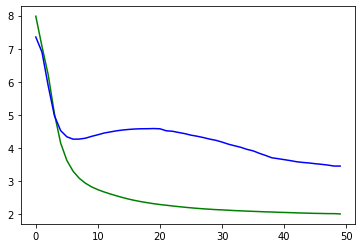

In [84]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')

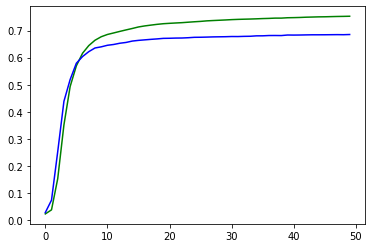

In [85]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')